In [1]:
%load_ext autoreload
%autoreload 2

Checked evaluation of cost functions and noted two discrepancies

1) in old version, x = W @ v produces slightly different x than irfft(z) (confirmed z = conv_v_to_z(z) was the same as in jax version)
2) very large discrepancy between prior portion of cost function for some values of z 

In [2]:
from cohlib.utils import gamma_root
gamma_root()

'/projectnb/stephenlab/jtauber/cohlib/hydra/gammas'

In [3]:
import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import jax
jax.config.update('jax_platform_name', 'cpu')

platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)

Platform:  cpu


In [4]:
len(jax.devices())

28

In [5]:
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.gaussian_obs import add0
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

from cohlib.jax.ts import load_results

### Data setup

In [6]:
flow = 1
fhigh = 50
scalep_target = 5
scalep_offtarget = 1

gamma_load = pickle_open(f'gammas/k2-full{flow}-{fhigh}-10-{scalep_target}-{scalep_offtarget}.pickle')
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
K = gamma_full.shape[1]

In [7]:
ov1 = 1
ov2 = -1
obs_var = ov1 * 10**ov2

In [8]:
scale_init = 10
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']

L = 25
init = 'flat-init'
emiters = 20
scale_init = 10
ovs_sel = None

supp = [0, 50]
res_load = load_results(res_paths, ovs_sel, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [9]:
cfg = res_load[ov2]['cfg']
lcfg = cfg.latent
ocfg = cfg.obs

lrk = jr.key(lcfg.seed)
ork = jr.key(ocfg.seed)

L = 25
zs = sample_from_gamma(lrk, gamma_full, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)


Visualizing the simulated data:

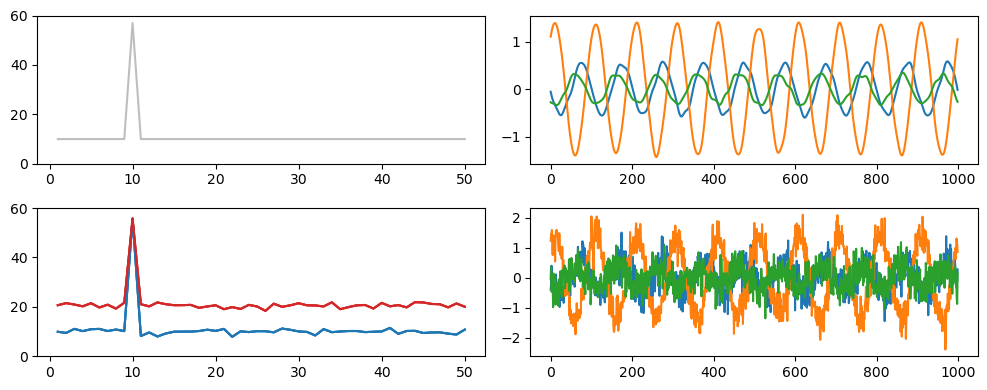

In [10]:
oracle_est = jnp.einsum('jkl,jil->jkil', zs, zs.conj()).mean(-1)
obs_f = jnp.fft.rfft(obs, axis=0)
zs_naive = obs_f[1:,:,:]
naive_est = jnp.einsum('jkl,jil->jkil', zs_naive, zs_naive.conj()).mean(-1)

dB = True
fig, ax = plt.subplots(2,2,figsize=(10,4))
S_true = gamma_full[nz,0,0].real
S_oracle = oracle_est[nz,0,0].real
S_naive = naive_est[nz,0,0].real
# ax[1,0].plot(S_true, color='tab:grey', alpha=0.5)

if dB == True:
    S_true = 10*jnp.log10(S_true+1e-15)
    S_oracle = 10*jnp.log10(S_oracle+1e-15)
    S_naive = 10*jnp.log10(S_naive+1e-15)

ax[0,0].plot(freqs[nz], S_true, color='tab:grey', alpha=0.5)
for l in range(3):
    ax[1,0].plot(freqs[nz], S_oracle, color='tab:blue')
    ax[1,0].plot(freqs[nz], S_naive, color='tab:red')
    ax[0,1].plot(xs[:,0,l])
    ax[1,1].plot(obs[:,0,l])
ax[0,0].set_ylim([0,60])
ax[1,0].set_ylim([0,60])
plt.tight_layout()

### Setting things up for both Jax / Old models


##### Jax model 

##### Old model setup

In [11]:
def conv_grad_old_r2c(grad_vec_real, K):
    rs = grad_vec_real.reshape(2,-1).swapaxes(0,1)
    grad_vec_complex = conv_v_to_z(rs, axis=0)
    return grad_vec_complex

conv_mus_old_r2c = conv_grad_old_r2c


In [12]:
def load_old(ov2, mu=0.0, K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    exp_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/gaussian_observations'
    ov2 = float(ov2)
    if hess_mod is True:
        model_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)
    else:
        model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)

    return model_load

old_model_load = load_old(ov2)
Wv = old_model_load['Wv']

In [13]:
from cohlib.alg.em_sgc import construct_Gamma_full_real, deconstruct_Gamma_full_real
from cohlib.utils import conv_z_to_v, conv_v_to_z
from cohlib.jax.ts import JvOExp, JaxOptim, OldOptim

In [14]:
def plot_jvo(jax_output, old_output, k, pltlim, suptitle, showyx=True):
    if pltlim is None:
        all_output = jnp.concatenate([jax_output[:,k].real, jax_output[:,k].imag, 
            old_output[:,k].real, old_output[:,k].imag])
        pltlim = all_output.max() * 1.2

    yxline = jnp.linspace(-pltlim, pltlim, 100)
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].plot(jax_output[:,k].real, old_output[:,k].real, '.')
    ax[0].set_title('Real')

    ax[1].plot(jax_output[:,k].imag, old_output[:,k].imag, '.')
    ax[1].set_title('Imag')

    for i in range(2):
        ax[i].set_xlim([-pltlim, pltlim])
        ax[i].set_ylim([-pltlim, pltlim])
        if showyx is True:
            ax[i].plot(yxline, yxline, 'k')
        ax[i].set_xlabel('Jax')
        ax[i].set_ylabel('Old')

    fig.suptitle(suptitle)
    plt.tight_layout()

In [15]:
from tqdm import tqdm

In [16]:
Nnz = nz.size
nz_target = jnp.array([9])

# gamma_inv_nonzero_init = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])*(1/nz_power_init)
# gamma_target_inv = jnp.copy(jnp.linalg.inv(gamma_full[nz_target,:,:]))

# gamma_inv_init = jnp.zeros_like((gamma_full))
# gamma_inv_init = gamma_inv_init.at[nz,:,:].set(gamma_inv_nonzero_init)
# gamma_inv_init = gamma_inv_init.at[nz_target,:,:].set(gamma_target_inv)

# gamma_init = jnp.zeros_like(gamma_full)
# gamma_init = gamma_init.at[nz,:,:].set(jnp.linalg.inv(gamma_inv_init[nz,:,:]))

gamma_inv_true = jnp.zeros_like((gamma_full))
gamma_inv_true = gamma_inv_true.at[nz,:,:].set(jnp.linalg.inv(gamma_full[nz,:,:]))

nz_power_init = 10
gamma_inv_flat = jnp.zeros_like((gamma_full))
gamma_inv_flat_nz = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])*(1/nz_power_init)
gamma_inv_flat = gamma_inv_flat.at[nz,:,:].set(gamma_inv_flat_nz)

In [20]:
L = 25
ov1 = 1
ov2 = -1
obs_var = ov1 * 10**ov2



zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

params_jax = {'freqs': freqs, 'nonzero_inds': nz}
params_jax_zsflat = {'freqs': freqs, 'nonzero_inds': nz, 'zs_flattened': True, 'K': K}
params_old = {'Wv': Wv, 'nonzero_inds': nz}

gamma_inv_use = gamma_inv_true
jaxmod_exp = JvOExp(obs, gamma_inv_use, obs_var, params_jax_zsflat, 'jax', track=True)

jaxmod_exp.e_step(10)

100%|██████████| 25/25 [00:26<00:00,  1.06s/it]


In [30]:
trial = 0
# zs_test = jnp.zeros((Nnz, K), dtype=complex)
zs_test = zs[nz,:,trial]
# omcost, omgrad, omhess = oldmod_exp.eval_cost(trial, zs_test)
# ocost, ograd, ohess = old_exp.eval_cost(trial, zs_test)
jcost, jgrad, jhess = jaxmod_exp.eval_cost(trial, zs_test)

In [51]:
params_jax_zsflat = {'freqs': freqs, 'nonzero_inds': nz, 'zs_flattened': True, 'K': K, 'obs_var': obs_var}
jaxmod_trial = JaxOptim(obs[:,:,trial], gamma_inv_use, params_jax_zsflat)
params_jax = {'freqs': freqs, 'nonzero_inds': nz, 'obs_var': obs_var}
jax_trial = JaxOptim(obs[:,:,trial], gamma_inv_use, params_jax)

In [52]:
jcost_flat = jaxmod_trial.cost_func(zs_test.flatten())
jgrad_flat = jaxmod_trial.cost_grad(zs_test.flatten())
jhess_flat = jaxmod_trial.cost_hess(zs_test.flatten())

jcost = jax_trial.cost_func(zs_test)
jgrad = jax_trial.cost_grad(zs_test)
jhess = jax_trial.cost_hess(zs_test)

In [54]:
print(jcost_flat)
print(jcost)

(1044.2009-2.4606578e-07j)
(1044.2009-2.4606578e-07j)


In [58]:
print(jnp.all(jgrad_flat.reshape(-1,K) == jgrad))

True


In [70]:
jhess_sel = jnp.stack([jhess[n,:,n,:] for n in range(Nnz)])
jhess_sel_flat = jnp.stack([jhess_flat[n*K:n*K+K,n*K:n*K+K] for n in range(Nnz)])

In [73]:
jnp.all(jhess_sel == jhess_sel_flat)

Array(True, dtype=bool)

In [68]:
j = 9
jhess_sel[j,:,:]

Array([[ 2.0004351e-02+5.5879357e-11j, -8.6956527e-07-8.6956527e-07j],
       [-8.6956527e-07+8.6956527e-07j,  2.0004351e-02+5.5879357e-11j]],      dtype=complex64)

In [69]:
jhess_flat[j*K:j*K+K,j*K:j*K+K]

Array([[ 2.0004351e-02+5.5879357e-11j, -8.6956527e-07-8.6956527e-07j],
       [-8.6956527e-07+8.6956527e-07j,  2.0004351e-02+5.5879357e-11j]],      dtype=complex64)